In [4]:
# standard
import pandas as pd
import numpy as np
import random

# tf and keras
import tensorflow as tf
import keras
from keras import layers
from sklearn.model_selection import train_test_split
from sklearn import ensemble
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV

# plots
import seaborn as sns
import matplotlib.pyplot as plt

# xgboost
import xgboost as xgb
import optuna
import optuna.visualization as vis

random.seed(42)

c:\Users\ashet\anaconda3\envs\ml\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# This is reading the cleaned dataframe from the cleaning notebook
df = pd.read_csv('./data/nn.csv')
#pd.options.display.max_columns = None
df = df[~df.landtaxvaluedollarcnt.isnull()]
df = df[~df.taxamount.isnull()]
df = df[~df.regionidzip.isnull()]
df = df[~df.structuretaxvaluedollarcnt.isnull()]

# Now we read in the housing index for LA County, and add the index for each month
dfh = pd.read_csv('data/LXXRNSA.csv')
dfh.DATE = pd.to_datetime(dfh.DATE)
df.transactiondate = pd.to_datetime(df.transactiondate)
df['transactionmonth'] =  df['transactiondate'].dt.strftime('%Y%m')
dfh.DATE = dfh['DATE'].dt.strftime('%Y%m')
df = pd.merge(df, dfh, left_on='transactionmonth', right_on='DATE', how='left')
df = df.drop(columns='DATE')

# Get month, year, weekday
df['month'] = df.transactionmonth.str[4:]
df['year'] = df.transactionmonth.str[:-2]
df['weekday'] = df.transactiondate.dt.day_of_week


In [6]:
X = df[['bedroomcnt','roomcnt','bathroomcnt','taxamount','landtaxvaluedollarcnt','taxvaluedollarcnt','structuretaxvaluedollarcnt',
        'latitude', 'longitude', 'LXXRNSA', 'month', 'year', 'weekday',
          'lotsizesquarefeet', 'calculatedfinishedsquarefeet', 'yearbuilt',
          ]]
Y = df.logerror

# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1234)

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=1234)

# Applying standardization to inputs

numeric_columns = ['bedroomcnt', 'roomcnt', 'bathroomcnt', 'taxamount',
       'landtaxvaluedollarcnt', 'taxvaluedollarcnt',
       'structuretaxvaluedollarcnt', 'latitude', 'longitude', 'LXXRNSA', 'calculatedfinishedsquarefeet',
        'lotsizesquarefeet', 'calculatedfinishedsquarefeet', 'yearbuilt',
         ]

# Standardize numeric columns
sc_x = StandardScaler()
X_train_std = X_train.copy()
X_val_std = X_val.copy()
# X_test_std = X_test.copy()

X_train_std[numeric_columns] = sc_x.fit(X_train[numeric_columns]).transform(X_train[numeric_columns])
X_val_std[numeric_columns] = sc_x.fit(X_train[numeric_columns]).transform(X_val[numeric_columns])
# X_test_std[numeric_columns] = sc_x.fit(X_train[numeric_columns]).transform(X_test[numeric_columns])

# Applying standardization to outputs
Y_train_std = (Y_train - Y_train.mean())/Y_train.std()
Y_val_std = (Y_val - Y_train.mean())/Y_train.std()
# Y_test_std = (Y_test - Y_train.mean())/Y_train.std()

# Mask missing data in last three columns - does this help? Apparently a tiny bit
mask_value = -999
X_train_std = X_train_std.fillna(mask_value)
X_val_std = X_val_std.fillna(mask_value)
# X_test_std = X_test_std.fillna(mask_value)

In [7]:
# THIS IS THE FUNCTION TO PREDICT MAE

# avg_error = Y_val_std.mean()
#y_true = np.array(Y)
#y_pred = np.ones(len(Y_val_std)) * avg_error
y_pred_main = np.zeros(len(Y_val_std))

def get_loss(y_true=Y_val_std, y_pred=y_pred_main):
    return tf.keras.losses.MAE(
    y_true, y_pred).numpy()

# Get loss of Zillow model
get_loss(y_true=Y_val)

0.06992945188768067

In [8]:
def build_model(lr):
    
    
    tf.keras.backend.clear_session()
    tf.random.set_seed(1234)
    random.seed(42)
    mask_value = -999
    

    bedroomcnt = layers.Input(shape=(1,), dtype=tf.float32, name='bedroomcnt')
    roomcnt = layers.Input(shape=(1,), dtype=tf.float32, name='roomcnt')
    bathroomcnt = layers.Input(shape=(1,), dtype=tf.float32, name='bathroomcnt')
    taxamount = layers.Input(shape=(1,), dtype=tf.float32, name='taxamount')
    landtaxvaluedollarcnt = layers.Input(shape=(1,), dtype=tf.float32, name='landtaxvaluedollarcnt')
    taxvaluedollarcnt = layers.Input(shape=(1,), dtype=tf.float32, name='taxvaluedollarcnt')
    structuretaxvaluedollarcnt = layers.Input(shape=(1,), dtype=tf.float32, name='structuretaxvaluedollarcnt')
    latitude = layers.Input(shape=(1,), dtype=tf.float32, name='latitude')
    longitude = layers.Input(shape=(1,), dtype=tf.float32, name='longitude')
    lxxrnsa = layers.Input(shape=(1,), dtype=tf.float32, name='lxxrnsa')
    month = layers.Input(shape=(1,), dtype=tf.string, name='month')
    year = layers.Input(shape=(1,), dtype=tf.string, name='year')
    weekday = layers.Input(shape=(1,), dtype=tf.int64, name='weekday')

    
    lotsizesquarefeet = layers.Input(shape=(1,), dtype=tf.int64, name='lotsizesquarefeet')
    lotsizemask = layers.Masking(mask_value=mask_value)(lotsizesquarefeet)

    calculatedfinishedsquarefeet = layers.Input(shape=(1,), dtype=tf.int64, name='calculatedfinishedsquarefeet')
    finishedsqftmask = layers.Masking(mask_value=mask_value)(calculatedfinishedsquarefeet)

    yearbuilt = layers.Input(shape=(1,), dtype=tf.int64, name='yearbuilt')
    yearblt = layers.Masking(mask_value=mask_value)(yearbuilt)


    month_id = tf.keras.layers.StringLookup(
      vocabulary=['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12'], 
      output_mode='one_hot')(month)
    
    year_id = tf.keras.layers.StringLookup(
      vocabulary=['2016', '2017'], 
      output_mode='one_hot')(year)   

    weekday_id = tf.keras.layers.IntegerLookup(
      vocabulary=[0,1,2,3,4,5,6], 
      output_mode='one_hot')(weekday) 

    resolution_in_degrees = 0.4

    # Create a list of numbers representing the bucket boundaries for latitude.
    latitude_boundaries = list(np.arange(-3, 3 + resolution_in_degrees, resolution_in_degrees))

    # Create a Discretization layer to separate the latitude data into buckets.
    latitude_discretized = tf.keras.layers.Discretization(
        bin_boundaries=latitude_boundaries,
        name='discretization_latitude')(latitude)

    # Create a list of numbers representing the bucket boundaries for longitude.
    longitude_boundaries = list(np.arange(-3, 3 + resolution_in_degrees, resolution_in_degrees))

    # Create a Discretization layer to separate the longitude data into buckets.
    longitude_discretized = tf.keras.layers.Discretization(
        bin_boundaries=longitude_boundaries,
        name='discretization_longitude')(longitude)

    # Cross the latitude and longitude features into a single one-hot vector.
    feature_cross = tf.keras.layers.HashedCrossing(
        num_bins=len(latitude_boundaries) * len(longitude_boundaries),
        output_mode='one_hot',
        name='cross_latitude_longitude')([latitude_discretized, longitude_discretized])

    features = layers.Concatenate()([
                    bedroomcnt, 
                    roomcnt, 
                    bathroomcnt, 
                    taxamount, 
                    landtaxvaluedollarcnt, 
                    taxvaluedollarcnt, 
                    structuretaxvaluedollarcnt,
                    feature_cross,
                    lxxrnsa,
                    month_id,
                    year_id,
                    weekday_id,
                    lotsizemask,
                    finishedsqftmask,
                    yearblt,
    ]) 
    print(features)


    x = layers.Dense(units=600, kernel_initializer='normal', activation='relu')(features)
    x = layers.Dropout(0.36)(x)
    x = layers.Dense(units=200, kernel_initializer='normal', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.6)(x)
    x = layers.Dense(1, kernel_initializer='normal')(x)
    x = layers.Dense(1, kernel_initializer='normal')(x)



    logerror = tf.keras.layers.Dense(
        units=1, activation='linear', name='logerror')(x)

    model = tf.keras.Model(inputs=[
        bedroomcnt, 
        roomcnt, 
        bathroomcnt, 
        taxamount, 
        landtaxvaluedollarcnt, 
        taxvaluedollarcnt, 
        structuretaxvaluedollarcnt,
        latitude,
        longitude,
        lxxrnsa,
        month,
        year,
        weekday,
        lotsizesquarefeet,
        calculatedfinishedsquarefeet,
        yearbuilt,
    ], outputs=logerror)
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss='mae',
        metrics=['mae'])

    return model

In [9]:
model = build_model(lr=0.002)
#model.summary()
#display(tf.keras.utils.plot_model(model))
random.seed(42)
tf.random.set_seed(1234)

history = model.fit(
    x={
        'bedroomcnt': X_train_std[['bedroomcnt']],
        'roomcnt': X_train_std[['roomcnt']],
        'bathroomcnt': X_train_std[['bathroomcnt']],
        'taxamount': X_train_std[['taxamount']],
        'landtaxvaluedollarcnt': X_train_std[['landtaxvaluedollarcnt']],
        'taxvaluedollarcnt': X_train_std[['taxvaluedollarcnt']],
        'structuretaxvaluedollarcnt': X_train_std[['structuretaxvaluedollarcnt']],
        'latitude': X_train_std[['latitude']],
        'longitude': X_train_std[['longitude']],
        'lxxrnsa': X_train_std[['LXXRNSA']],
        'year': X_train_std[['year']],  
        'month': X_train_std[['month']],  
        'weekday': X_train_std[['weekday']],
        'lotsizesquarefeet': X_train_std[['lotsizesquarefeet']],
        'calculatedfinishedsquarefeet': X_train_std[['calculatedfinishedsquarefeet']],
        'yearbuilt': X_train_std[['yearbuilt']],

    },
    y=Y_train_std,
    epochs=5,
    batch_size=128,
    validation_data=(
        {
            'bedroomcnt': X_val_std[['bedroomcnt']],
            'roomcnt': X_val_std[['roomcnt']],
            'bathroomcnt': X_val_std[['bathroomcnt']],
            'taxamount': X_val_std[['taxamount']],
            'landtaxvaluedollarcnt': X_val_std[['landtaxvaluedollarcnt']],
            'taxvaluedollarcnt': X_val_std[['taxvaluedollarcnt']],
            'structuretaxvaluedollarcnt': X_val_std[['structuretaxvaluedollarcnt']],
            'latitude': X_val_std[['latitude']],
            'longitude': X_val_std[['longitude']],
            'lxxrnsa': X_val_std[['LXXRNSA']],
            'year': X_val_std[['year']], 
            'month': X_val_std[['month']], 
            'weekday': X_val_std[['weekday']],
            'lotsizesquarefeet': X_val_std[['lotsizesquarefeet']],
            'calculatedfinishedsquarefeet': X_val_std[['calculatedfinishedsquarefeet']],
            'yearbuilt': X_val_std[['yearbuilt']],
        },
        Y_val_std
    )
)


<KerasTensor shape=(None, 291), dtype=float32, sparse=False, name=keras_tensor_15>
Epoch 1/5
1046/1046 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - loss: 0.4186 - mae: 0.4186 - val_loss: 0.4219 - val_mae: 0.4219
Epoch 2/5
1046/1046 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 0.4176 - mae: 0.4176 - val_loss: 0.4218 - val_mae: 0.4218
Epoch 3/5
1046/1046 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 0.4174 - mae: 0.4174 - val_loss: 0.4216 - val_mae: 0.4216
Epoch 4/5
1046/1046 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 0.4171 - mae: 0.4171 - val_loss: 0.4216 - val_mae: 0.4216
Epoch 5/5
1046/1046 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 0.4171 - mae: 0.4171 - val_loss: 0.4215 - val_mae: 0.4215


In [10]:
val_preds = model.predict({
        'bedroomcnt': X_val_std[['bedroomcnt']],
        'roomcnt': X_val_std[['roomcnt']],
        'bathroomcnt': X_val_std[['bathroomcnt']],
        'taxamount': X_val_std[['taxamount']],
        'landtaxvaluedollarcnt': X_val_std[['landtaxvaluedollarcnt']],
        'taxvaluedollarcnt': X_val_std[['taxvaluedollarcnt']],
        'structuretaxvaluedollarcnt': X_val_std[['structuretaxvaluedollarcnt']],
        'latitude': X_val_std[['latitude']],
        'longitude': X_val_std[['longitude']],
        'lxxrnsa': X_val_std[['LXXRNSA']],
        'year': X_val_std[['year']], 
        'month': X_val_std[['month']],
        'weekday': X_val_std[['weekday']],
        'lotsizesquarefeet': X_val_std[['lotsizesquarefeet']],
        'calculatedfinishedsquarefeet': X_val_std[['calculatedfinishedsquarefeet']],
        'yearbuilt': X_val_std[['yearbuilt']],
        
    })

# Convert to regular scale from scaled-standardized scale
val_preds= (val_preds[:,0]*Y_train.std()) + Y_train.mean()
get_loss(y_pred=val_preds, y_true=Y_val)

1046/1046 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step


0.069189526

### XGBoost

In [11]:
train_preds = model.predict({
        'bedroomcnt': X_train_std[['bedroomcnt']],
        'roomcnt': X_train_std[['roomcnt']],
        'bathroomcnt': X_train_std[['bathroomcnt']],
        'taxamount': X_train_std[['taxamount']],
        'landtaxvaluedollarcnt': X_train_std[['landtaxvaluedollarcnt']],
        'taxvaluedollarcnt': X_train_std[['taxvaluedollarcnt']],
        'structuretaxvaluedollarcnt': X_train_std[['structuretaxvaluedollarcnt']],
        'latitude': X_train_std[['latitude']],
        'longitude': X_train_std[['longitude']],
        'lxxrnsa': X_train_std[['LXXRNSA']],
        'year': X_train_std[['year']],  
        'month': X_train_std[['month']],  
        'weekday': X_train_std[['weekday']],
        'lotsizesquarefeet': X_train_std[['lotsizesquarefeet']],
        'calculatedfinishedsquarefeet': X_train_std[['calculatedfinishedsquarefeet']],
        'yearbuilt': X_train_std[['yearbuilt']],
    })

val_preds = model.predict({
        'bedroomcnt': X_val_std[['bedroomcnt']],
        'roomcnt': X_val_std[['roomcnt']],
        'bathroomcnt': X_val_std[['bathroomcnt']],
        'taxamount': X_val_std[['taxamount']],
        'landtaxvaluedollarcnt': X_val_std[['landtaxvaluedollarcnt']],
        'taxvaluedollarcnt': X_val_std[['taxvaluedollarcnt']],
        'structuretaxvaluedollarcnt': X_val_std[['structuretaxvaluedollarcnt']],
        'latitude': X_val_std[['latitude']],
        'longitude': X_val_std[['longitude']],
        'lxxrnsa': X_val_std[['LXXRNSA']],
        'year': X_val_std[['year']], 
        'month': X_val_std[['month']],
        'weekday': X_val_std[['weekday']],
        'lotsizesquarefeet': X_val_std[['lotsizesquarefeet']],
        'calculatedfinishedsquarefeet': X_val_std[['calculatedfinishedsquarefeet']],
        'yearbuilt': X_val_std[['yearbuilt']],
    })



4181/4181 ━━━━━━━━━━━━━━━━━━━━ 18s 4ms/step
1046/1046 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step


In [13]:
d_train = xgb.DMatrix(train_preds, label = Y_train_std)
d_valid = xgb.DMatrix(val_preds, label = Y_val_std)

In [15]:
params = {}
params['eta'] = 0.02
params['objective'] = 'reg:squarederror'
params['eval_metric'] = 'mae'
params['max_depth'] = 1
params['silent'] = 1

watchlist = [(d_train, 'train'), (d_valid, 'valid')]
clf = xgb.train(params, d_train, 1000, watchlist,
                early_stopping_rounds=100, verbose_eval=10)

[0]	train-mae:0.41942	valid-mae:0.42691


c:\Users\ashet\anaconda3\envs\ml\Lib\site-packages\xgboost\core.py:723: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
c:\Users\ashet\anaconda3\envs\ml\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:51:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[10]	train-mae:0.41865	valid-mae:0.42621
[20]	train-mae:0.41812	valid-mae:0.42575
[30]	train-mae:0.41776	valid-mae:0.42544
[40]	train-mae:0.41746	valid-mae:0.42521
[50]	train-mae:0.41724	valid-mae:0.42503
[60]	train-mae:0.41704	valid-mae:0.42487
[70]	train-mae:0.41688	valid-mae:0.42475
[80]	train-mae:0.41675	valid-mae:0.42466
[90]	train-mae:0.41665	valid-mae:0.42460
[100]	train-mae:0.41657	valid-mae:0.42455
[110]	train-mae:0.41651	valid-mae:0.42452
[120]	train-mae:0.41647	valid-mae:0.42451
[130]	train-mae:0.41644	valid-mae:0.42451
[140]	train-mae:0.41642	valid-mae:0.42451
[150]	train-mae:0.41640	valid-mae:0.42452
[160]	train-mae:0.41639	valid-mae:0.42452
[170]	train-mae:0.41639	valid-mae:0.42454
[180]	train-mae:0.41638	valid-mae:0.42454
[190]	train-mae:0.41638	valid-mae:0.42456
[200]	train-mae:0.41639	valid-mae:0.42457
[210]	train-mae:0.41639	valid-mae:0.42459
[220]	train-mae:0.41640	valid-mae:0.42461
[230]	train-mae:0.41641	valid-mae:0.42463
[233]	train-mae:0.41641	valid-mae:0.42463


In [16]:
# Get final loss, it's bad
forest_val = (clf.predict(d_valid)*Y_train.std()) + Y_train.mean()
get_loss(y_pred=forest_val, y_true=Y_val)

0.0697121

### Hyperparameter Tuning

In [18]:

# Define the objective function
def objective(trial):
    params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'mae',
        'eta': trial.suggest_float('eta', 0.01, 0.1),
        'max_depth': trial.suggest_int('max_depth', 1, 9),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'lambda': trial.suggest_float('lambda', 1e-8, 1.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-8, 1.0, log=True)
    }
        
    # Train the model
    model = xgb.train(params, d_train, num_boost_round=1000, evals=watchlist,
                      early_stopping_rounds=100, verbose_eval=False)
    
    # Return the best validation MAE
    val_mae = model.best_score
    return val_mae

# Create a study object and optimize the objective function
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100, timeout=600)

# Print the best parameters
print(f"Best Parameters: {study.best_params}")


[I 2024-08-04 12:52:14,702] A new study created in memory with name: no-name-e7476c05-6ad4-4e75-abe5-7396810111d4
[I 2024-08-04 12:52:18,743] Trial 0 finished with value: 0.42466538901704753 and parameters: {'eta': 0.021891280668566063, 'max_depth': 6, 'subsample': 0.6426508708876639, 'colsample_bytree': 0.724689978636257, 'lambda': 0.10531877947587076, 'alpha': 0.02712769698514286}. Best is trial 0 with value: 0.42466538901704753.
[I 2024-08-04 12:52:22,413] Trial 1 finished with value: 0.42471122506319176 and parameters: {'eta': 0.03891277265259157, 'max_depth': 6, 'subsample': 0.9957094867092299, 'colsample_bytree': 0.9444806160905179, 'lambda': 8.400121339528692e-07, 'alpha': 0.002777388974730232}. Best is trial 0 with value: 0.42466538901704753.
[I 2024-08-04 12:52:24,647] Trial 2 finished with value: 0.4244901194906469 and parameters: {'eta': 0.054532821753224464, 'max_depth': 1, 'subsample': 0.9808767998962851, 'colsample_bytree': 0.8816139491606669, 'lambda': 4.233266884294445e

Best Parameters: {'eta': 0.03645539443085783, 'max_depth': 1, 'subsample': 0.6585870586005471, 'colsample_bytree': 0.782952071578565, 'lambda': 0.0003767376751845663, 'alpha': 5.605457358072697e-07}


In [22]:
best_opts = {'eta': 0.03645539443085783, 
             'max_depth': 1, 
             'subsample': 0.6585870586005471, 
             'colsample_bytree': 0.782952071578565, 
             'lambda': 0.0003767376751845663, 
             'alpha': 5.605457358072697e-07,
             'eval_metric' : 'mae'}


In [23]:
clf = xgb.train(
    best_opts,
    d_train,
    num_boost_round=1000,  # Choose a suitable number of boosting rounds
    evals=watchlist,
    early_stopping_rounds=100,
    verbose_eval=10
)

[0]	train-mae:0.41935	valid-mae:0.42685


[10]	train-mae:0.41814	valid-mae:0.42576
[20]	train-mae:0.41749	valid-mae:0.42521
[30]	train-mae:0.41704	valid-mae:0.42486
[40]	train-mae:0.41675	valid-mae:0.42463
[50]	train-mae:0.41653	valid-mae:0.42450
[60]	train-mae:0.41644	valid-mae:0.42445
[70]	train-mae:0.41632	valid-mae:0.42439
[80]	train-mae:0.41629	valid-mae:0.42439
[90]	train-mae:0.41633	valid-mae:0.42446
[100]	train-mae:0.41633	valid-mae:0.42450
[110]	train-mae:0.41633	valid-mae:0.42453
[120]	train-mae:0.41639	valid-mae:0.42461
[130]	train-mae:0.41642	valid-mae:0.42466
[140]	train-mae:0.41648	valid-mae:0.42473
[150]	train-mae:0.41653	valid-mae:0.42481
[160]	train-mae:0.41657	valid-mae:0.42486
[170]	train-mae:0.41662	valid-mae:0.42492
[175]	train-mae:0.41662	valid-mae:0.42492


In [24]:
# Get final loss, it's identical!
xgb_val = (clf.predict(d_valid)*Y_train.std()) + Y_train.mean()
get_loss(y_pred=forest_val, y_true=Y_val)

0.0697121

In [ ]:
# Optimization history plot
opt_history_fig = vis.plot_optimization_history(study)
opt_history_fig.show()

In [ ]:
# Parameter importance plot
param_importance_fig = vis.plot_param_importances(study)
param_importance_fig.show()

In [ ]:
# Slice plot
slice_fig = vis.plot_slice(study)
slice_fig.show()

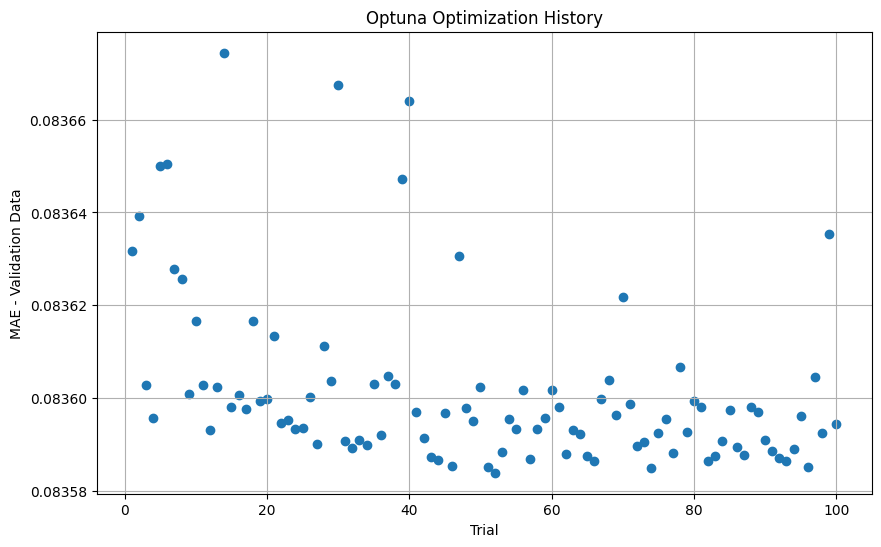

In [26]:
# Extract values from the study
trial_values = [trial.value for trial in study.trials]

# Apply the transformation: (value * a) + b
transformed_values = [(value * Y_train.std()) + Y_train.mean() for value in trial_values]

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(range(1,101,1), transformed_values)
plt.xlabel('Trial')
plt.ylabel('MAE - Validation Data')
plt.title('Optuna Optimization History')
plt.grid(True)
plt.show()